In [1]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#Data Preparation and Exploration

In [2]:
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.1, random_state=101)

In [4]:
X_train.shape, y_train.shape

((45000, 32, 32, 3), (45000, 1))

In [5]:
X_valid.shape, y_valid.shape

((5000, 32, 32, 3), (5000, 1))

In [6]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [7]:
class_names = ['airplane', 'automobile', 'bird','cat','deer','dog','frog','horse','ship','truck']

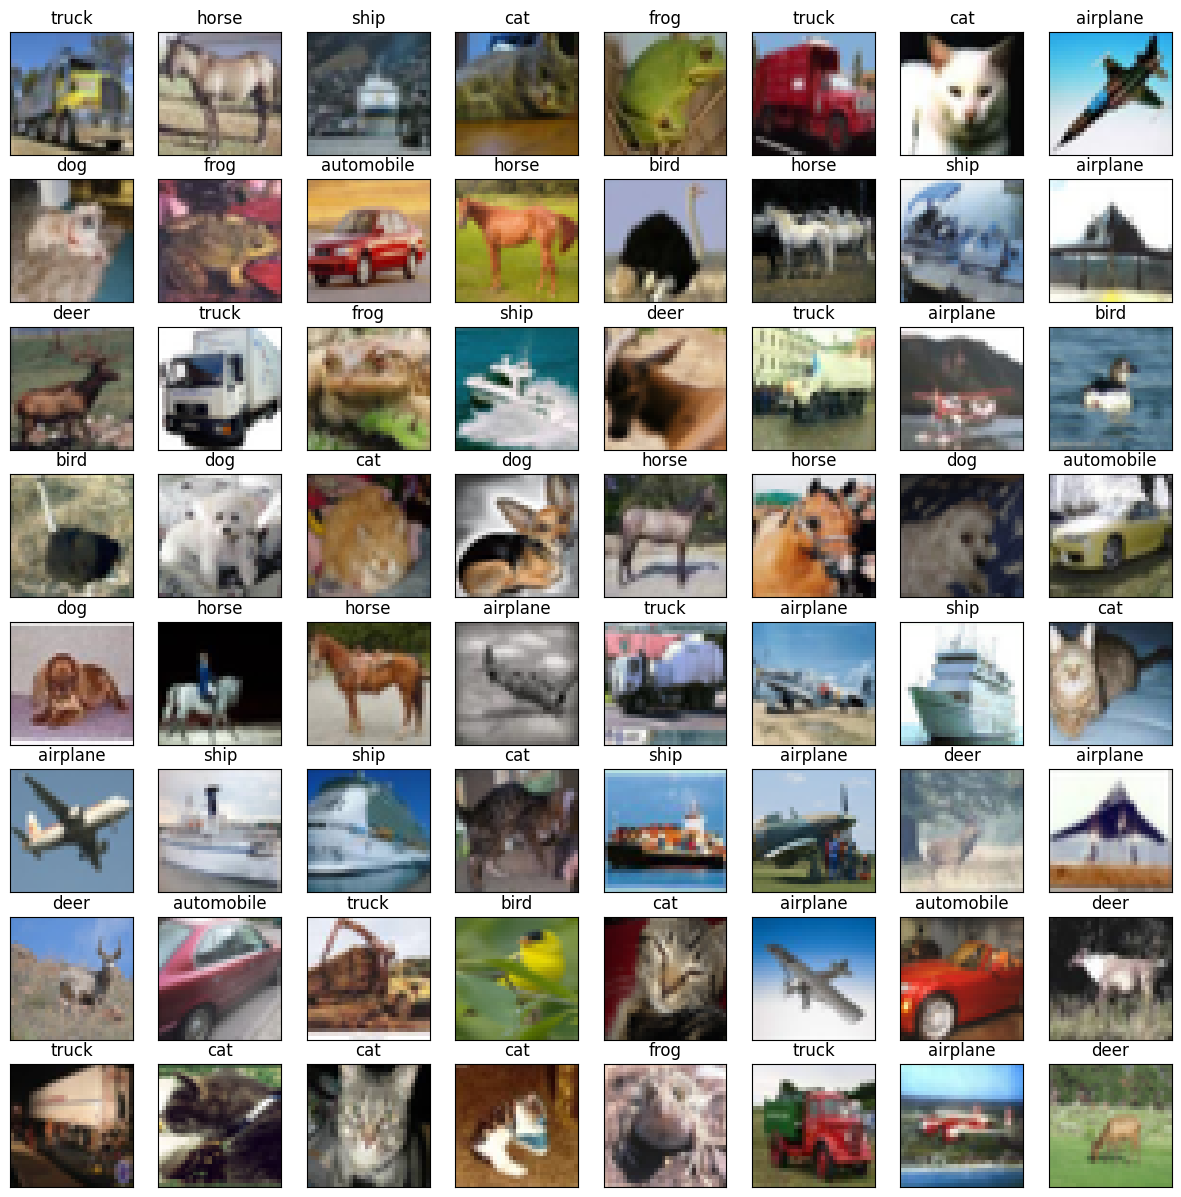

In [8]:
plt.figure(figsize=(15,15))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train[i])
  plt.title(class_names[y_train[i][0]])

plt.show()

# Data Preprocssing

1. Normalisation of images
2. One hot encoding of Labels
3. Data Augmentation

#### Normalisation

In [9]:
#Converting pixel values to float32

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

#Calculate the mean and std of training images
mean = np.mean(X_train)
std = np.std(X_train)

#Normalize the data
X_train = (X_train-mean)/(std+.00000001)
X_test = (X_test-mean)/(std+.00000001)
X_valid = (X_valid-mean)/(std+.00000001)

#### One Hot Encoding of Labels

In [10]:
y_train = to_categorical(y_train,10)
y_valid = to_categorical(y_valid,10)
y_test = to_categorical(y_test,10)

#### Data Augmentation

In [11]:
data_generator = ImageDataGenerator(
    rotation_range = 15, #rotate images by up to 15 degree
    width_shift_range = .12, #shift images horizontally by upto 12% of width
    height_shift_range = 0.12,
    horizontal_flip =True,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    shear_range = 10, #Shear intesity (share angle in anti clockwise direction),
    channel_shift_range = 0.1
)

## Model

In [12]:
model = Sequential()

weight_decay = 0.0001 #weight decay for l2 regularization

model.add(Conv2D(filters=32, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay), input_shape = X_train.shape[1:]))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

#Add first max pooling layer with pool size of 2*2
model.add(MaxPooling2D(pool_size=(2,2)))
#Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))


#Add the third and fourth Conv layers
model.add(Conv2D(filters=64, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

#Add 2nd max pooling layer with pool size of 2*2
model.add(MaxPooling2D(pool_size=(2,2)))
#Add dropout layer with 0.3 dropout rate
model.add(Dropout(rate=0.3))


model.add(Conv2D(filters=128, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

#Add 3rd max pooling layer with pool size of 2*2
model.add(MaxPooling2D(pool_size=(2,2)))
#Add dropout layer with 0.4 dropout rate
model.add(Dropout(rate=0.4))


model.add(Conv2D(filters=256, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size = (3,3), padding='same', activation = 'relu', kernel_regularizer =l2(weight_decay)))
model.add(BatchNormalization())


#Add 4th max pooling layer with pool size of 2*2
model.add(MaxPooling2D(pool_size=(2,2)))
#Add dropout layer with 0.5 dropout rate
model.add(Dropout(rate=0.5))


#Flatten the tensor output from the previous layer
model.add(Flatten())

#Add a fully connected layer with softmax activation function
model.add(Dense(10,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,186,346 (4.53 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [14]:
# Set the batch size
batch_size =64

epochs = 150 #instead of 150, run this for 300/400 epochs

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience = 10, min_lr = .00001)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 40, restore_best_weights=True, verbose=1)

model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_valid, y_valid),
                              callbacks = [reduce_lr, early_stopping],
                              verbose=2)

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 - 73s - 103ms/step - accuracy: 0.3389 - loss: 2.3167 - val_accuracy: 0.4574 - val_loss: 1.7102 - learning_rate: 5.0000e-04
Epoch 2/150
704/704 - 46s - 65ms/step - accuracy: 0.4557 - loss: 1.7347 - val_accuracy: 0.5406 - val_loss: 1.5702 - learning_rate: 5.0000e-04
Epoch 3/150
704/704 - 44s - 63ms/step - accuracy: 0.5199 - loss: 1.5298 - val_accuracy: 0.5790 - val_loss: 1.3406 - learning_rate: 5.0000e-04
Epoch 4/150
704/704 - 43s - 62ms/step - accuracy: 0.5690 - loss: 1.3741 - val_accuracy: 0.6106 - val_loss: 1.2490 - learning_rate: 5.0000e-04
Epoch 5/150
704/704 - 44s - 63ms/step - accuracy: 0.6089 - loss: 1.2482 - val_accuracy: 0.6650 - val_loss: 1.0853 - learning_rate: 5.0000e-04
Epoch 6/150
704/704 - 43s - 61ms/step - accuracy: 0.6404 - loss: 1.1569 - val_accuracy: 0.6762 - val_loss: 1.0519 - learning_rate: 5.0000e-04
Epoch 7/150
704/704 - 44s - 62ms/step - accuracy: 0.6660 - loss: 1.0833 - val_accuracy: 0.6888 - val_loss: 1.0219 - learning_rate: 5.0000e-04
Epoch 8/150
704/7

## Visualizing the Learning Curves

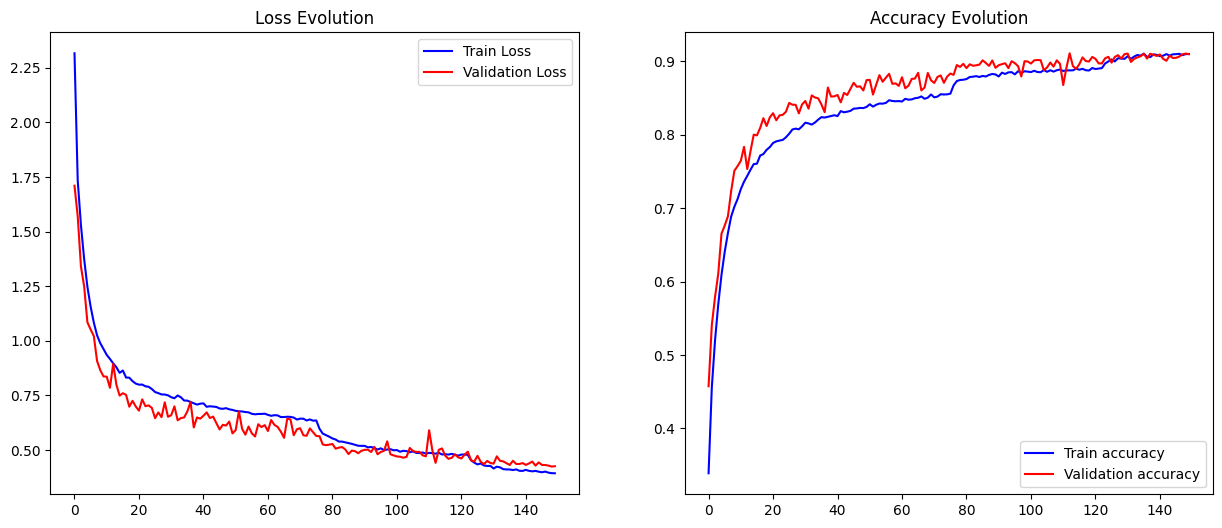

In [15]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(model.history.history['loss'], label = 'Train Loss', color = 'blue')
plt.plot(model.history.history['val_loss'], label = 'Validation Loss', color = 'red')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1,2,2)
plt.plot(model.history.history['accuracy'], label = 'Train accuracy', color = 'blue')
plt.plot(model.history.history['val_accuracy'], label = 'Validation accuracy', color = 'red')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

## Evaluating the Optimal Model on Test Data

In [16]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose = 1)

print(f'Test Accuracy : {test_acc}\nTestLoss: {test_loss}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8996 - loss: 0.4534
Test Accuracy : 0.8981999754905701
TestLoss: 0.4565945267677307


# performance on an out of Dataset image

In [27]:
url = 'https://naturealberta.ca/wp-content/uploads/2025/04/6.-Tree-Swallow-NICK-CARTER-1536x1340.jpg'
#'https://wildjolie.com/cdn/shop/articles/Do_Horses_Have_Horns.jpg?v=1741247407&width=1780'
reps = urllib.request.urlopen(url)
image = np.asarray(bytearray(reps.read()),dtype='uint8')
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert the image from bgr to rgb

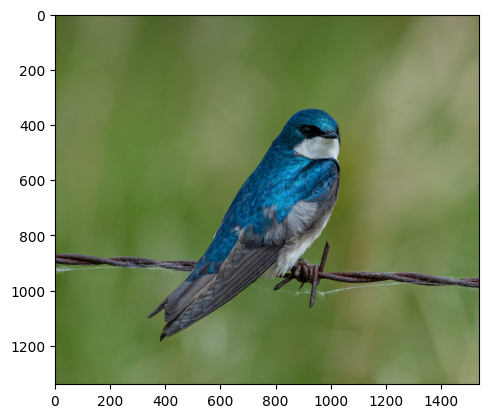

In [28]:
plt.imshow(image)
plt.show()

In [29]:
image.shape

(1340, 1536, 3)

In [30]:
image = cv2.resize(image, (32,32))

#normalize the image
image = (image-mean)/(std+0.000001)

#Add an exyra dimension because the model expects a batch of images
image = image.reshape((1,32,32,3))

In [31]:
predict = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [32]:
predict

array([[2.4491452e-02, 4.2718969e-07, 9.7496337e-01, 3.6845449e-05,
        6.2495637e-06, 5.3080323e-05, 3.3813060e-04, 8.8041706e-05,
        1.8674367e-06, 2.0444273e-05]], dtype=float32)

In [33]:
print(f'The predicted class: {class_names[predict.argmax()]}')

The predicted class: bird
